In [2]:
import matplotlib as mpl

In [4]:
mpl.style.use('bmh')
mpl.style.use('ggplot')
mpl.rcParams['axes.formatter.useoffset']=False

## Preprocessing
First, read in all ground calib data and convert to single HDF5 file.

In [1]:
import glob
files = glob.glob('/raid1/maye/ground_calib/*_EDR.TAB')
files.sort()

In [2]:
def read_and_process(filename):
    df = pd.read_csv(filename, comment='#', skipinitialspace=True)
    df = df.rename(columns=lambda x:x.strip())
    df.index = pd.to_datetime(df.DATE + ' ' + df.UTC)
    return df

In [3]:
# Commenting out to prevent accidental run
# for filename in files:
#     print filename
#     df = read_and_process(filename)
#     df.to_hdf('/raid1/maye/ground_calib/all_data.h5', 'df', 
#               mode='a', append=True)

In [4]:
hsk_files = glob.glob('/raid1/maye/ground_calib/hsk/*_hsk.csv')
hsk_files.sort()

In [5]:
# Commented out to prevent from running

# for filename in hsk_files:
#     print filename
#     df = read_and_process(filename)
#     df.to_hdf('/raid1/maye/ground_calib/house_keeping.h5','df',
#               mode='a', append=True)

## Calculations

In [6]:
hsk = pd.read_hdf('/raid1/maye/ground_calib/house_keeping.h5','df')
hsk[hsk < -9998.0] = np.nan

In [7]:
# read in all calib data
df = pd.read_hdf('/raid1/maye/ground_calib/all_data.h5', 'df')
df = df['2008-01-10 18:00':'2008-01-16 19:00']
df[df < -9998.0] = np.nan 

Mark Foote:
>Since you bugged me about it again, I just did it.  I looked at some B3 (ch9) data with the two blackbodies at 90 K and 33 K.  The difference in signal was 45 counts, and the noise is about 2.5 counts, for a signal to noise ratio of 18.  My modelled value  is 16.  Note that I just eyeballed the noise and calculated the stdev as p-p divided by 4 or 5.

>Looking at two different transitions with the cold blackbody at 34.2 and 31.8K, I measured a signal difference of 45 and 46 counts (plus and minus a count or two!).  With this guestimate of 1 count for a 2.4 K difference in scene temperature, and my noise guesstimate of 2.5 counts, I get NETD = 2.5 counts / 1 count * 2.4 K = 6 K, compared to my modelled value of 6.4 K at 33 K.

In [8]:
[i for i in df.columns if 'TEMP' in i.upper()]

['TEMP_FAULT',
 'FPA_TEMP',
 'FPB_TEMP',
 'BAFFLE_A_TEMP',
 'BAFFLE_B_TEMP',
 'BB_1_TEMP',
 'OBA_1_TEMP',
 'HYBRID_TEMP',
 'FPA_TEMP_CYC',
 'FPB_TEMP_CYC',
 'BAFFLE_A_TEMP_CYC',
 'BAFFLE_B_TEMP_CYC',
 'OBA_1_TEMP_CYC',
 'OBA_2_TEMP',
 'BB_1_TEMP_CYC',
 'BB_2_TEMP',
 'SOLAR_TARGET_TEMP',
 'YOKE_TEMP',
 'EL_ACTUATOR_TEMP',
 'AZ_ACTUATOR_TEMP',
 'SOLAR_BASE_TEMP']

In [9]:
[(i,hsk[i].min()) for i in hsk.columns if 'temp' in i.lower()]

[('TEMP_FAULT', 0.0),
 ('FPA_TEMP', 283.32999999999998),
 ('FPB_TEMP', 283.67700000000002),
 ('BAFFLE_A_TEMP', 283.27800000000002),
 ('BAFFLE_B_TEMP', 283.35200000000003),
 ('BB_1_TEMP', 286.44999999999999),
 ('OBA_1_TEMP', 285.13799999999998),
 ('HYBRID_TEMP', -120.26799999999999),
 ('FPA_TEMP_CYC', 283.33299999999997),
 ('FPB_TEMP_CYC', 283.68799999999999),
 ('BAFFLE_A_TEMP_CYC', 283.303),
 ('BAFFLE_B_TEMP_CYC', 283.38200000000001),
 ('OBA_1_TEMP_CYC', 285.15300000000002),
 ('OBA_2_TEMP', 284.74000000000001),
 ('BB_1_TEMP_CYC', 286.53399999999999),
 ('BB_2_TEMP', 286.38599999999997),
 ('SOLAR_TARGET_TEMP', 242.34299999999999),
 ('YOKE_TEMP', 285.37599999999998),
 ('EL_ACTUATOR_TEMP', 280.20999999999998),
 ('AZ_ACTUATOR_TEMP', 285.012),
 ('SOLAR_BASE_TEMP', 258.392)]

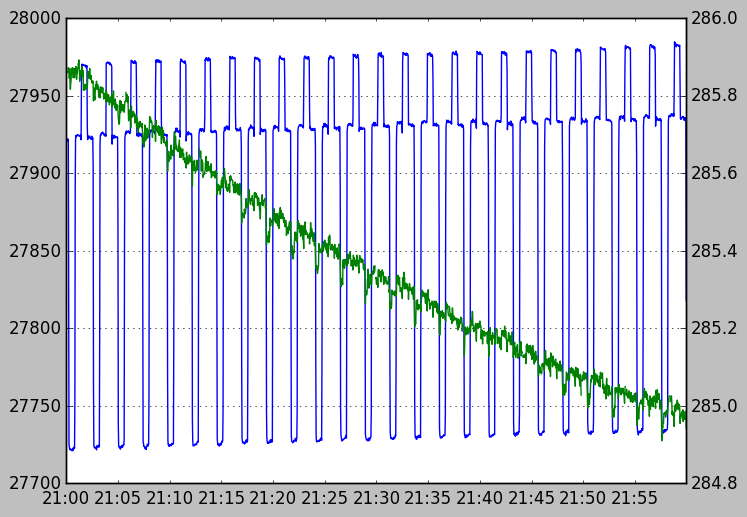

In [10]:
t = '20080110 21'
df[t].B3_11.resample('2s').plot()
hsk[t].FPB_TEMP.resample('2s').plot(secondary_y=True)

## Looking into in-flight house keeping

In [2]:
tstr = '2011030400'
tstr = '2009072712'
tstr = '2010020303'
# tstr = '2013052119'
df = fu.open_and_accumulate(tstr)
# obs = fu.DivObs(tstr)
# df = obs.get_l1a()

In [3]:
rdr2 = calib.Calibrator(df)
rdr2.calibrate()

INFO:diviner.calib:Calibrating from 2010-02-03 02:00:01.774000 to 2010-02-03 05:00:00.949000.
INFO:diviner.calib:Performing radiance correction on 2010-02-03 02:00:01.774000


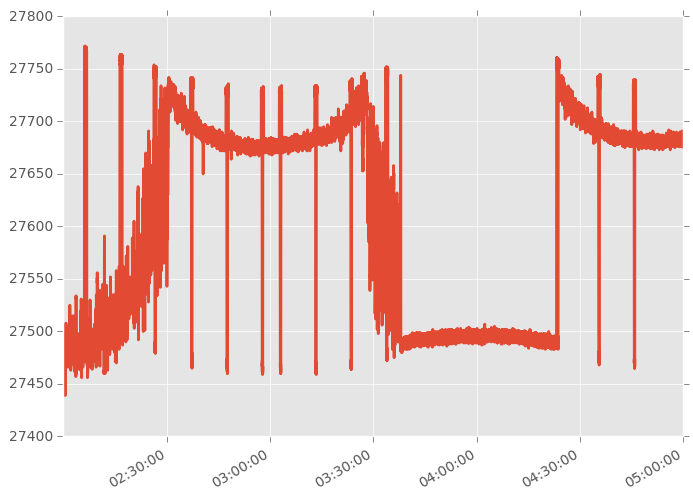

In [4]:
df.b3_11.plot()

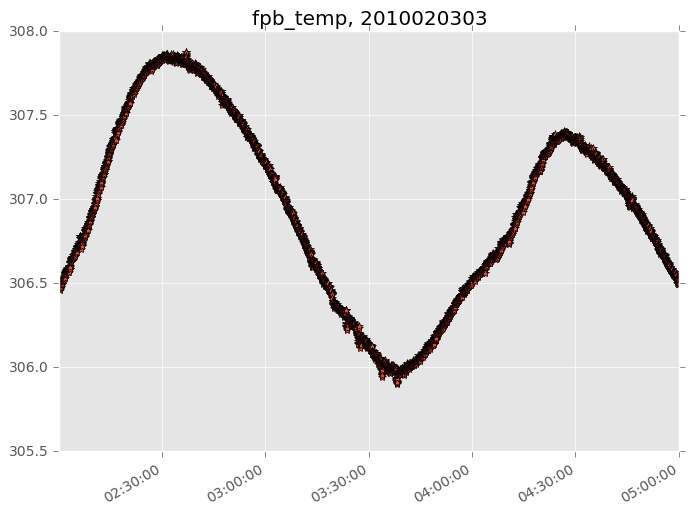

In [5]:
df.fpb_temp.plot(style='*')
title('fpb_temp, {}'.format(tstr))
savefig('/u/paige/maye/plots/fpb_temp_{}.png'.format(tstr))

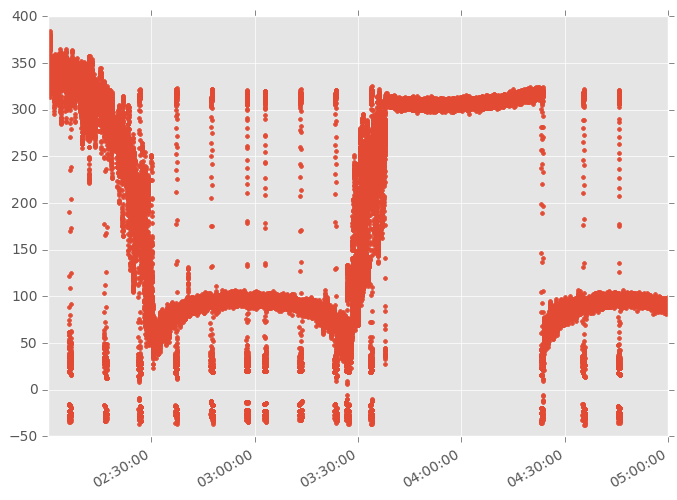

In [10]:
rdr2.Tb.b3_11.plot(style='.')

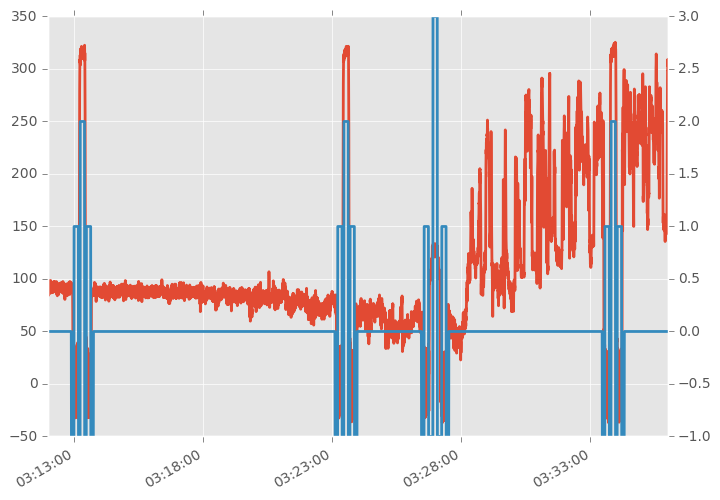

In [21]:
t1 = '2010-02-03 03:12'
t2 = '2010-02-03 03:35'
rdr2.Tb[t1:t2].b3_11.plot()
df.sdtype[t1:t2].plot(secondary_y=True)
# df.last_el_cmd[t1:t2].plot(secondary_y=True)

In [22]:
def get_std(group):
    return group.b3_11[16:].std()

grouped = df.groupby('space_block_labels')
space_stds = grouped.apply(get_std)

In [23]:
rdr2.offsets

,a1_01,a1_02,a1_03,a1_04,a1_05,a1_06,a1_07,a1_08,a1_09,a1_10,...,b3_12,b3_13,b3_14,b3_15,b3_16,b3_17,b3_18,b3_19,b3_20,b3_21
2010-02-03 02:06:28.798000,22284.570312,22230.148438,22224.804688,22237.132812,22259.742188,22254.078125,22302.453125,22289.195312,22286.140625,22305.984375,...,27706.210938,27732.539062,27726.492188,27684.085938,27715.335938,27716.210938,27687.593750,27707.140625,27729.234375,27690.828125
2010-02-03 02:16:45.272500,22270.757812,22215.898438,22210.375000,22222.679688,22245.289062,22239.015625,22287.859375,22274.093750,22271.546875,22291.898438,...,27699.601562,27725.171875,27719.007812,27675.921875,27708.000000,27707.726562,27678.335938,27696.507812,27717.000000,27677.382812
2010-02-03 02:26:39.195000,22269.812500,22216.984375,22211.781250,22225.000000,22246.945312,22240.648438,22289.640625,22275.484375,22272.757812,22292.546875,...,27687.578125,27713.585938,27707.593750,27665.328125,27696.476562,27697.296875,27668.789062,27689.789062,27711.945312,27675.562500
2010-02-03 02:37:18.183000,22283.976562,22236.234375,22231.179688,22244.148438,22266.773438,22260.546875,22309.304688,22295.078125,22291.750000,22311.062500,...,27676.328125,27702.617188,27697.617188,27655.804688,27688.187500,27690.945312,27665.414062,27689.468750,27718.054688,27690.789062
2010-02-03 02:47:34.643000,22298.718750,22252.187500,22247.671875,22260.781250,22283.164062,22277.109375,22325.859375,22311.632812,22307.046875,22326.656250,...,27670.218750,27697.335938,27692.742188,27651.390625,27685.257812,27689.585938,27665.265625,27692.562500,27725.187500,27702.882812
2010-02-03 02:57:49.055000,22315.445312,22271.187500,22266.367188,22279.375000,22302.367188,22295.304688,22344.812500,22329.570312,22325.609375,22344.796875,...,27668.664062,27695.523438,27691.875000,27651.585938,27685.718750,27690.351562,27668.195312,27697.023438,27731.992188,27712.585938
2010-02-03 03:03:04.444000,22324.773438,22280.687500,22276.429688,22289.460938,22312.000000,22305.546875,22354.898438,22340.187500,22335.531250,22353.875000,...,27669.835938,27697.179688,27693.273438,27653.187500,27687.351562,27692.390625,27670.078125,27699.859375,27735.273438,27717.835938
2010-02-03 03:13:20.902000,22341.687500,22299.046875,22294.914062,22308.132812,22330.382812,22323.859375,22372.875000,22358.085938,22353.531250,22371.890625,...,27671.312500,27697.968750,27694.898438,27654.554688,27690.257812,27695.921875,27673.789062,27704.523438,27741.789062,27726.585938
2010-02-03 03:23:33.264000,22351.468750,22308.359375,22303.953125,22316.906250,22339.750000,22333.046875,22382.187500,22367.203125,22362.898438,22380.726562,...,27676.187500,27703.570312,27700.375000,27660.507812,27695.437500,27699.812500,27678.031250,27709.039062,27745.570312,27729.000000
2010-02-03 03:27:00.115500,22349.109375,22304.835938,22300.273438,22313.101562,22335.851562,22329.000000,22378.257812,22363.867188,22359.437500,22377.453125,...,27680.007812,27707.218750,27704.132812,27664.382812,27698.539062,27703.617188,27681.265625,27711.054688,27747.570312,27729.117188


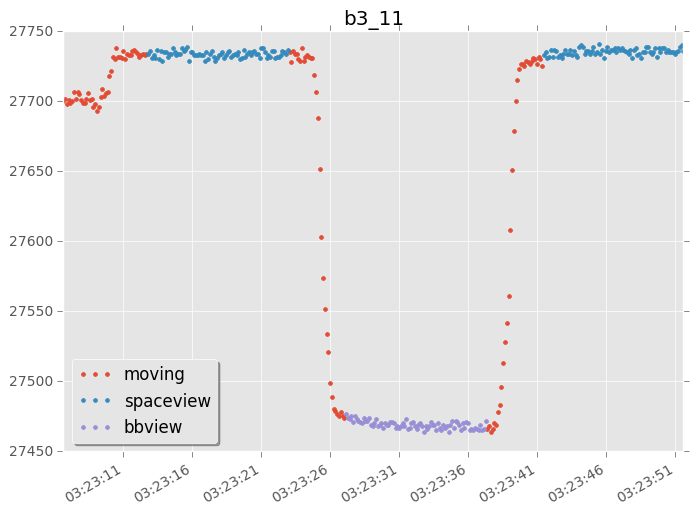

In [25]:
pu.plot_calib_block(df, 'calib', 9, 'b3_11')

In [83]:
mean_times = grouped.apply(calib.get_mean_time)

In [84]:
fpb = grouped.fpb_temp.mean()

In [125]:
mean_counts = grouped.b3_11.mean()

In [126]:
results = pd.concat([space_stds, mean_times, fpb, mean_counts],axis=1)

In [127]:
results.columns = ['STD', 'time', 'fpb_temp', 'mean_counts']

In [128]:
results = results.set_index('time')
results = results.iloc[1:]

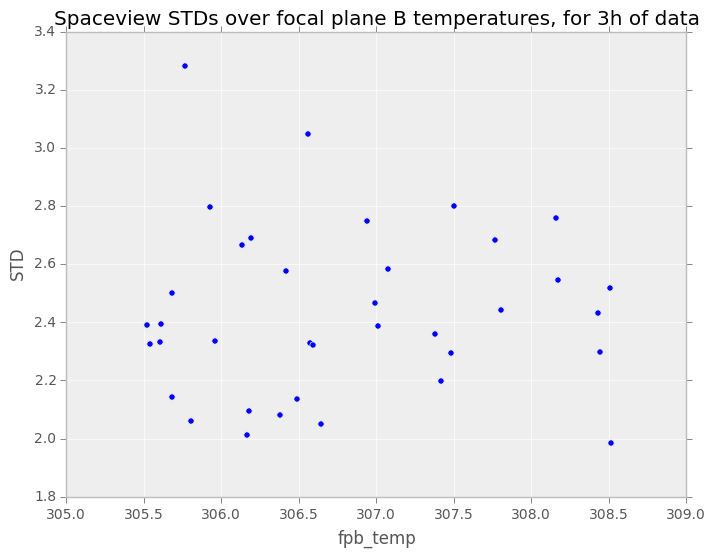

In [108]:
results.plot('fpb_temp','STD', kind='scatter', 
                      title='Spaceview STDs over focal plane B temperatures, for 3h of data')
savefig('/u/paige/maye/plots/scatter_std_to_fpb_temp.png', dpi=150)

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84368 entries, 2011-03-03 23:00:01.046000 to 2011-03-04 02:00:00.190000
Columns: 258 entries, q to b3_11_tb
dtypes: bool(6), float64(51), int32(4), int64(193), object(4)

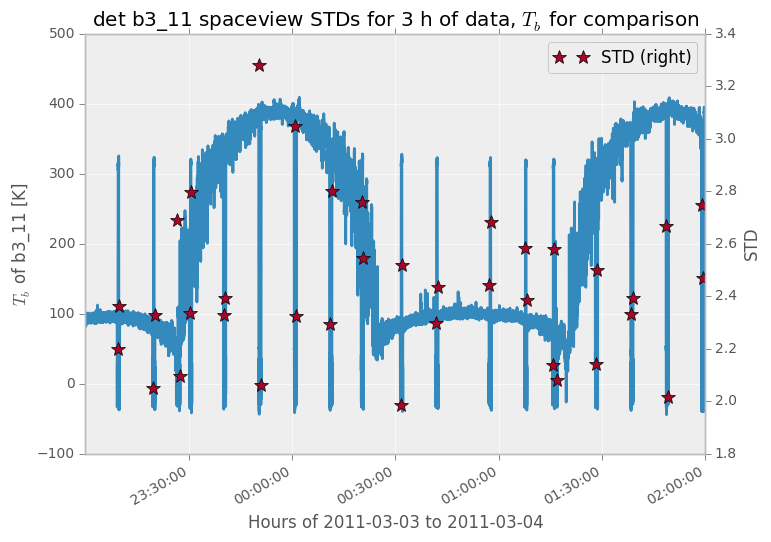

In [109]:
rdr2.Tb.b3_11.plot(legend=True)
ax = gca()
ax.set_xlabel('Hours of 2011-03-03 to 2011-03-04')
ax.set_ylabel('$T_b$ of b3_11 [K]')
legend()
results.STD.plot(style='*', ms=10, secondary_y=True,legend=True)
ax = gca()
ax.set_ylabel('STD')
ax.set_title('det b3_11 spaceview STDs for 3 h of data, $T_b$ for comparison')
savefig('/u/paige/maye/plots/stds_and_tb_over_time.png', dpi=150)

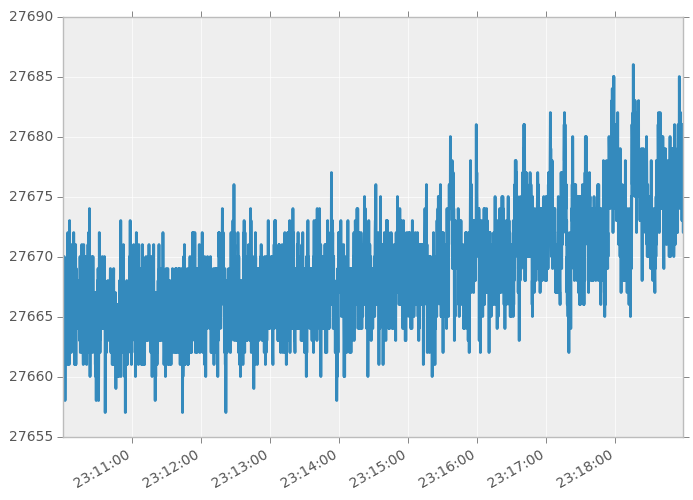

In [164]:
t1 = '20110303 23:10'
t2 = '20110303 23:18'
subdf = df.loc[t1:t2]
subdf.b3_11.plot()
savefig('/u/paige/maye/plots/area_of_interest.png',dpi=150)

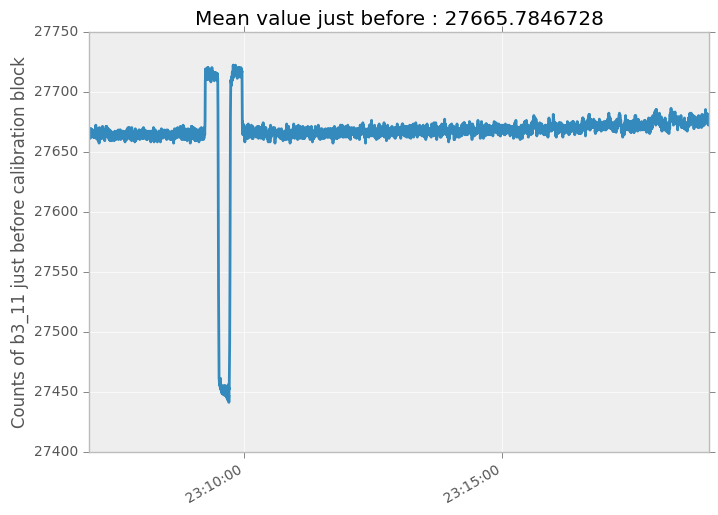

In [182]:
t1 = '20110303 23:07'
t2 = '20110303 23:18'
subdf = df.loc[t1:t2]
subdf.b3_11.plot()
title('Mean value just before : {}'.format(subdf.b3_11.mean()))
ylabel('Counts of b3_11 just before calibration block')
savefig('/u/paige/maye/plots/mean_counts_before_calblock2.png',dpi=150)

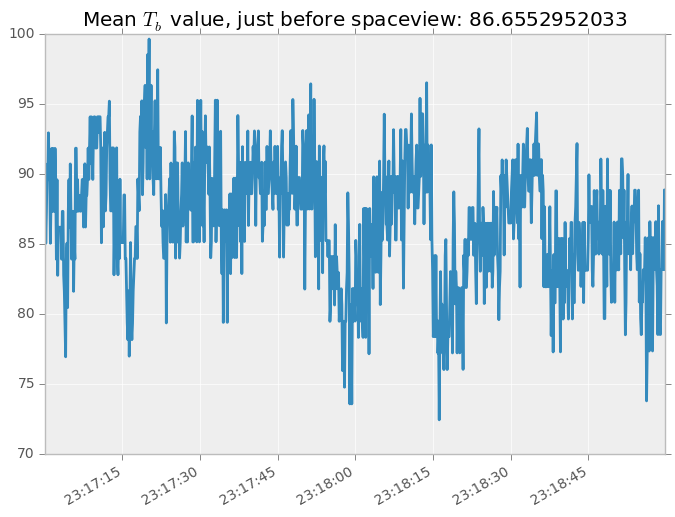

In [178]:
rdr2.Tb.b3_11.loc[t1:t2].plot()
title("Mean $T_b$ value, just before spaceview: {}".format(rdr2.Tb.b3_11.loc[t1:t2].mean()))
savefig("/u/paige/maye/plots/temps_before_calblock2.png", dpi=150)

In [180]:
# SNR
(results.mean_counts[3] - subdf.b3_11.mean())/results.STD[3]

19.094447120649487

In [169]:
results.head()

,STD,fpb_temp,mean_counts
time,,,
2011-03-03 23:09:23.163000,2.197525,307.4162,27714.2625
2011-03-03 23:09:51.835500,2.360387,307.3806,27716.3125
2011-03-03 23:19:39.617000,2.049426,306.6422,27716.0625
2011-03-03 23:20:08.289000,2.329078,306.5732,27718.1875
2011-03-03 23:26:45.605000,2.689633,306.1906,27721.8875


In [151]:
27714 - 27664

50

In [170]:
50 / 2.36

21.186440677966104

In [184]:
results.iloc[:4].mean()

STD                2.234104
fpb_temp         307.003050
mean_counts    27716.206250
dtype: float64

## Coldregions

In [16]:
ls /raid1/maye/coldregions/

calib.log                     region1_tb_old.png  region_sp3_9.txt
my_calib/                     region3/            region_sp5_9.txt
no_rad_corr/                  region5/            region_sp_newtb_added_test.h5
old_data_radiance_binned.png  regions_data.h5     sp_region1_9.h5
region1/                      region_sp1_9.txt    tstring_2009070808.h5


In [17]:
cd /raid1/maye/coldregions/

/raid1/maye/coldregions


In [ ]:
!less region_sp1_9.txt

                 date                month                 year                 hour           
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.000000000       2009.000000000          8.000000000          7
          8.000000000          7.0000000